# Data Preparation Pipeline Demo

This notebook demonstrates the complete training data generation pipeline:

1. **synthetic_case_generator.py** → Generate LaTeX editing specifications
2. **generate_tikzcd.py** → Render LaTeX to images

## Training Data Format
```
Input:  (latex_context, cropped_edit_region_image)
Output: (updated_latex)
```

## 1. Setup & Imports

In [ ]:
import sys
import os

# Verify PyMuPDF is available
try:
    import fitz
    print(f"PyMuPDF: {fitz.version}")
except ImportError:
    print("PyMuPDF not installed! Run: pip install pymupdf")
    raise

# Import our modules
from synthetic_case_generator import (
    CaseGenerator,
    TrainingExample,
    EditOperation,
    CropRegionSpec,
    NoiseGenerator
)

from generate_tikzcd import (
    render_tikzcd_to_image,
    generate_training_dataset,
    generate_training_example_image,
    TikzCDGenerator,
    HAS_PYMUPDF,
    HAS_PDF2IMAGE,
    _init_pdf_converters
)

# Ensure converters are initialized
_init_pdf_converters()
print(f"Renderers: PyMuPDF={HAS_PYMUPDF}, pdf2image={HAS_PDF2IMAGE}")

import matplotlib.pyplot as plt
from PIL import Image
import tempfile

print("Setup complete!")

PyMuPDF: ('1.26.7', '1.26.12', None)
Renderers: PyMuPDF=True, pdf2image=False
Setup complete!


## 2. Test LaTeX Rendering

Verify the rendering pipeline works with simple examples.

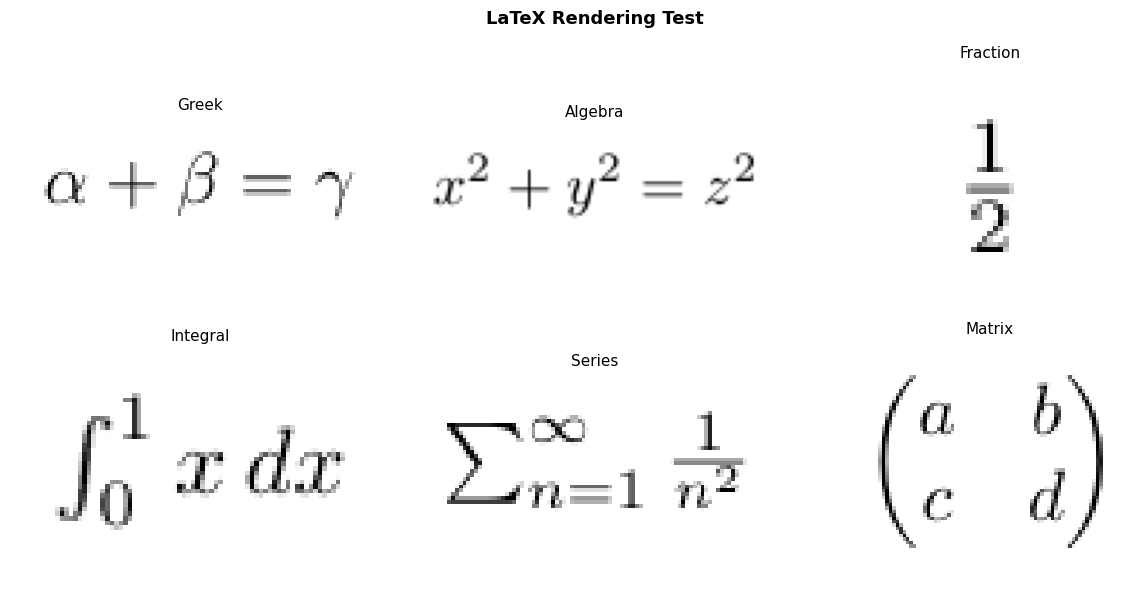

In [2]:
# Test rendering individual LaTeX expressions
test_cases = [
    (r"$\alpha + \beta = \gamma$", "Greek"),
    (r"$x^2 + y^2 = z^2$", "Algebra"),
    (r"$\frac{1}{2}$", "Fraction"),
    (r"$\int_0^1 x\,dx$", "Integral"),
    (r"$\sum_{n=1}^{\infty} \frac{1}{n^2}$", "Series"),
    (TikzCDGenerator.matrix_2x2("a", "b", "c", "d"), "Matrix"),  # Already has \[...\]
]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for ax, (latex, title) in zip(axes, test_cases):
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        tmp_path = tmp.name
    
    success = render_tikzcd_to_image(latex, tmp_path, dpi=150)
    
    if success and os.path.exists(tmp_path):
        img = Image.open(tmp_path)
        ax.imshow(img)
        ax.set_title(title, fontsize=11)
        os.remove(tmp_path)
    else:
        ax.text(0.5, 0.5, "Failed", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(f"{title} (failed)", fontsize=11)
    ax.axis("off")

fig.suptitle("LaTeX Rendering Test", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

## 3. Generate Training Cases

Use `CaseGenerator` from `cases.py` to create editing scenarios.

In [3]:
# Initialize case generator
generator = CaseGenerator(seed=42)

# Generate cases from all categories
cases = generator.generate_all(count_per_category=5)
print(f"Generated {len(cases)} cases")

# Show category distribution
from collections import Counter
categories = Counter(c.category for c in cases)
print("\nCategories:")
for cat, count in sorted(categories.items()):
    print(f"  {cat}: {count}")

Generated 119 cases

Categories:
  algebra: 10
  calculus: 10
  diagram: 12
  diffeq: 4
  fraction: 4
  greek: 4
  matrix: 10
  single_symbol: 55
  subscript_superscript: 10


In [4]:


# Show sample cases
print("Sample cases:")
print("=" * 60)

for case in cases[:5]:
    print(f"\n[{case.category}] {case.operation}")
    print(f"  Before: {case.before_latex[:50]}..." if len(case.before_latex) > 50 else f"  Before: {case.before_latex}")
    print(f"  After:  {case.after_latex[:50]}..." if len(case.after_latex) > 50 else f"  After:  {case.after_latex}")
    print(f"  Description: {case.edit_description}")

Sample cases:

[matrix] ADD
  Before: \begin{pmatrix} i & 0 \\ 0 & i \end{pmatrix}
  After:  \begin{pmatrix} i_{2} & 0 \\ 0 & i_{2} \end{pmatri...
  Description: Add subscript 2 to i

[algebra] REPLACE
  Before: x^2 - y
  After:  x^2 + y
  Description: Replace operator - -> +

[diagram] ADD
  Before: \begin{tikzcd} I \arrow[r, \"k\"] & B_2 \end{tikzc...
  After:  \begin{tikzcd} I \arrow[r, \"k\"] & B_2 \arrow[r, ...
  Description: Add node \mathcal{C} with arrow n

[single_symbol] ADD
  Before: c
  After:  c_{0}
  Description: Add digit 0 as subscript

[single_symbol] ADD
  Before: \theta
  After:  \theta^{3}
  Description: Add superscript 3 to \theta


## 4. Convert to Training Examples

Convert `EditCase` objects to `TrainingExample` format with noise augmentation.

In [5]:
# Convert to training examples with noise
training_examples = generator.convert_to_training_examples(
    cases[:20],  # First 20 cases
    add_noise=True,
    noise_probability=0.4
)

print(f"Created {len(training_examples)} training examples")

# Statistics
initial_count = sum(1 for e in training_examples if e.is_initial_state)
noisy_count = sum(1 for e in training_examples if e.crop_spec.noise_specs)

print(f"\nStatistics:")
print(f"  Initial state (empty context): {initial_count}")
print(f"  With noise augmentation: {noisy_count}")

Created 20 training examples

Statistics:
  Initial state (empty context): 2
  With noise augmentation: 9


In [6]:
# Show a training example
ex = training_examples[0]
print("Training Example Structure:")
print("=" * 60)
print(f"ID: {ex.id}")
print(f"Operation: {ex.operation}")
print(f"Category: {ex.category}/{ex.subcategory}")
print(f"Initial state: {ex.is_initial_state}")
print(f"\nINPUT:")
print(f"  latex_context: '{ex.latex_context}'")
print(f"  crop_spec: x={ex.crop_spec.x:.2f}, y={ex.crop_spec.y:.2f}")
print(f"  noise: {ex.crop_spec.noise_types if ex.crop_spec.noise_specs else 'None'}")
print(f"\nOUTPUT:")
print(f"  updated_latex: '{ex.updated_latex}'")
print(f"  edit_symbol: '{ex.edit_symbol}'")

Training Example Structure:
ID: matrix_add_0003
Operation: ADD
Category: matrix/add_element
Initial state: False

INPUT:
  latex_context: '\begin{pmatrix} i & 0 \\ 0 & i \end{pmatrix}'
  crop_spec: x=0.57, y=0.70
  noise: None

OUTPUT:
  updated_latex: '\begin{pmatrix} i_{2} & 0 \\ 0 & i_{2} \end{pmatrix}'
  edit_symbol: 'unknown'


## 5. Generate Training Images

Use `generate_training_dataset` to render actual images.

In [7]:
import shutil

# Output directory
output_dir = "demo_output"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Generate dataset
print("Generating training images...")
result = generate_training_dataset(
    training_examples[:10],  # First 10 examples
    output_dir=output_dir,
    max_examples=10,
    verbose=True
)

print(f"\nResult: {result['stats']}")

Generating training images...
Processing 10/10...

Dataset generated in demo_output
  Success: 8
  Failed: 2

Result: {'success': 8, 'failed': 2, 'skipped': 0}


In [8]:
# List generated files
print("Generated files:")
for root, dirs, files in os.walk(output_dir):
    level = root.replace(output_dir, "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files[:5]:
        print(f"{indent}  {f}")
    if len(files) > 5:
        print(f"{indent}  ... and {len(files)-5} more")

Generated files:
demo_output/
  dataset.json
  context_images/
    algebra_replace_0002_context.png
    algebra_replace_0004_context.png
    calculus_add_0004_context.png
    matrix_add_0003_context.png
    matrix_replace_0003_context.png
    ... and 2 more
  crop_images/
    algebra_replace_0002_crop.png
    algebra_replace_0004_crop.png
    calculus_add_0004_crop.png
    initial_0017_crop.png
    matrix_add_0003_crop.png
    ... and 3 more
  target_images/
    algebra_replace_0002_target.png
    algebra_replace_0004_target.png
    calculus_add_0004_target.png
    initial_0017_target.png
    matrix_add_0003_target.png
    ... and 3 more


## 6. Visualize Generated Data

Display context → edit → target flow.

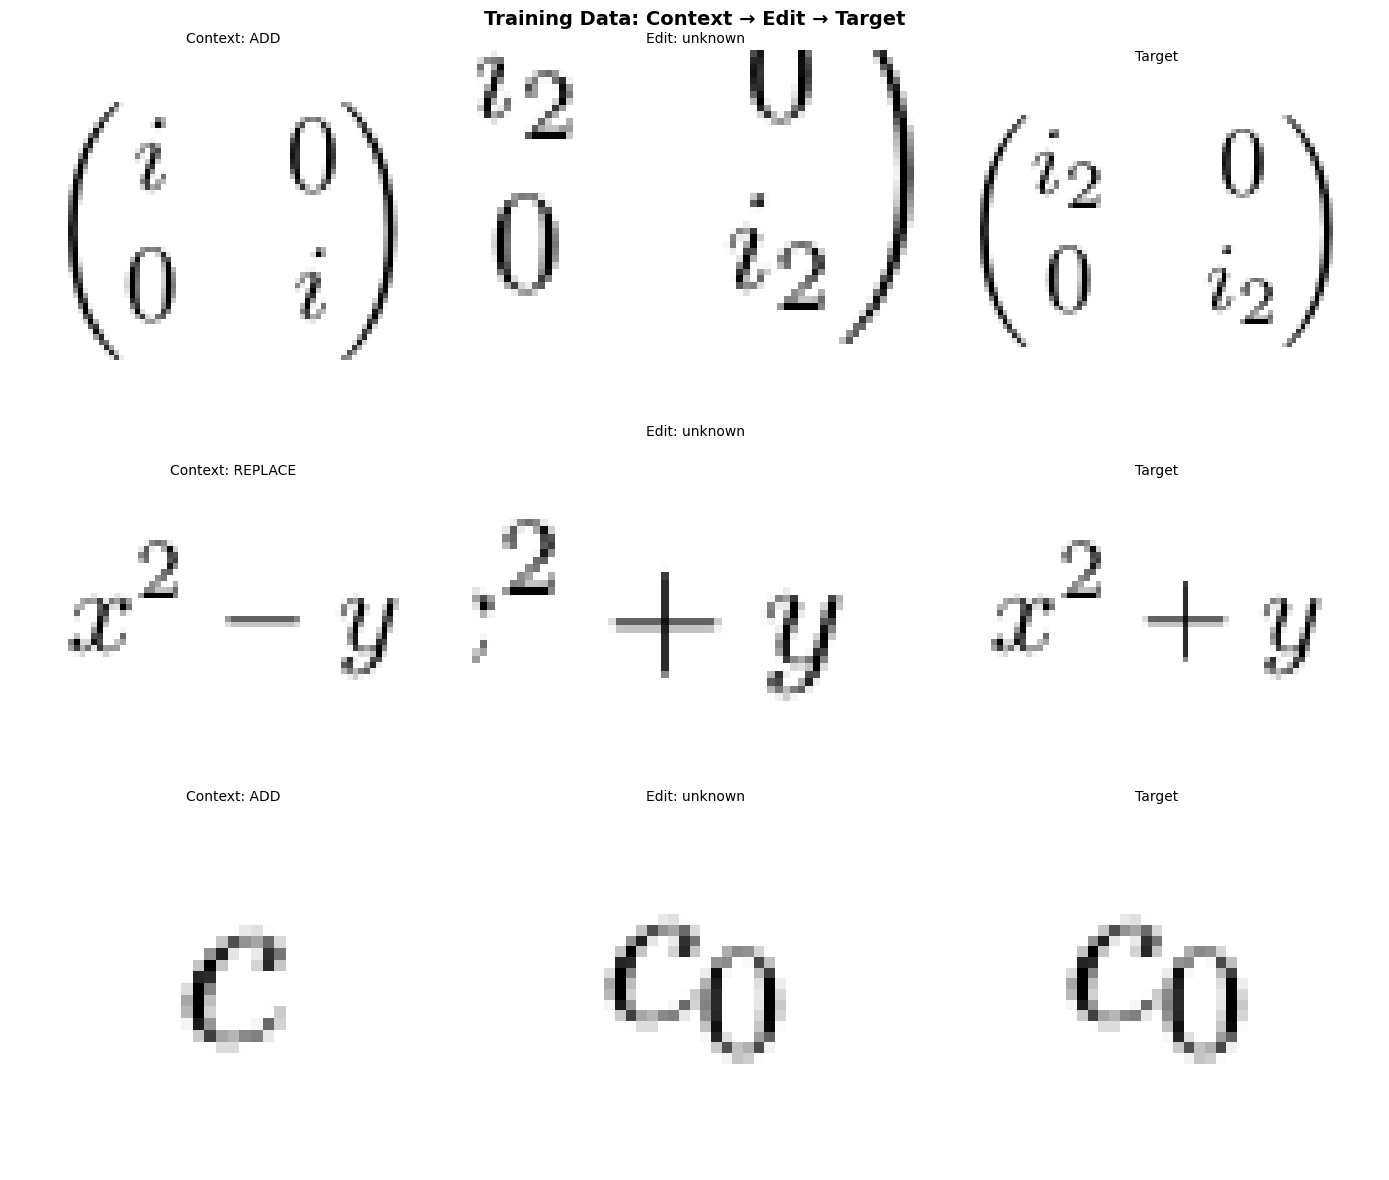

In [9]:
import json

# Load metadata
with open(f"{output_dir}/dataset.json", "r") as f:
    dataset = json.load(f)

# Show examples with images
examples_with_images = [e for e in dataset["examples"] if e.get("target_image")]
num_show = min(3, len(examples_with_images))

if num_show > 0:
    fig, axes = plt.subplots(num_show, 3, figsize=(14, 4 * num_show))
    if num_show == 1:
        axes = axes.reshape(1, -1)
    
    for idx, ex in enumerate(examples_with_images[:num_show]):
        # Context
        ax = axes[idx, 0]
        ctx_path = f"{output_dir}/{ex.get('context_image', '')}"
        if os.path.exists(ctx_path):
            ax.imshow(Image.open(ctx_path))
        else:
            ax.text(0.5, 0.5, "(empty)", ha="center", va="center", transform=ax.transAxes, fontsize=14)
            ax.set_facecolor("#f0f0f0")
        ax.set_title(f"Context: {ex['operation']}", fontsize=10)
        ax.axis("off")
        
        # Edit symbol
        ax = axes[idx, 1]
        crop_path = f"{output_dir}/{ex.get('crop_image', '')}"
        if os.path.exists(crop_path):
            ax.imshow(Image.open(crop_path))
        else:
            ax.text(0.5, 0.5, ex.get("edit_symbol", "?"), ha="center", va="center", 
                    transform=ax.transAxes, fontsize=20, color="blue")
            ax.set_facecolor("#e8f5e9")
        ax.set_title(f"Edit: {ex.get('edit_symbol', '?')}", fontsize=10)
        ax.axis("off")
        
        # Target
        ax = axes[idx, 2]
        target_path = f"{output_dir}/{ex.get('target_image', '')}"
        if os.path.exists(target_path):
            ax.imshow(Image.open(target_path))
        else:
            ax.text(0.5, 0.5, "(failed)", ha="center", va="center", transform=ax.transAxes)
        ax.set_title("Target", fontsize=10)
        ax.axis("off")
    
    fig.suptitle("Training Data: Context → Edit → Target", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()
else:
    print("No examples with images found.")

## 7. Advanced Examples: Diagrams & Differential Equations

Generate and visualize more complex cases including commutative diagrams and differential equations.


In [10]:
# Generate specific category examples
diagram_cases = generator.generate_by_category("diagram", count=6)
diffeq_cases = generator.generate_by_category("diffeq", count=6)

print("=== Commutative Diagram Examples ===")
for case in diagram_cases[:3]:
    print(f"\n[{case.subcategory}] {case.operation}")
    print(f"  Before: {case.before_latex[:80]}..." if len(case.before_latex) > 80 else f"  Before: {case.before_latex}")
    print(f"  After:  {case.after_latex[:80]}..." if len(case.after_latex) > 80 else f"  After:  {case.after_latex}")

print("\n=== Differential Equation Examples ===")
for case in diffeq_cases[:3]:
    print(f"\n[{case.subcategory}] {case.operation}")
    print(f"  Before: {case.before_latex}")
    print(f"  After:  {case.after_latex}")


=== Commutative Diagram Examples ===

[add_label] ADD
  Before: \begin{tikzcd} U \arrow[r] & P \end{tikzcd}
  After:  \begin{tikzcd} U \arrow[r, \"h\"] & P \end{tikzcd}

[insert_node] INSERT
  Before: \begin{tikzcd} F \arrow[r, \"\eta\"] & X' \end{tikzcd}
  After:  \begin{tikzcd} F \arrow[r, \"f \circ g\"] & P \arrow[r, \"m\"] & X' \end{tikzcd}

[insert_node] INSERT
  Before: \begin{tikzcd} B_2 \arrow[r, \"h\"] & Z' \end{tikzcd}
  After:  \begin{tikzcd} B_2 \arrow[r, \"p\"] & X_n \arrow[r, \"m\"] & Z' \end{tikzcd}

=== Differential Equation Examples ===

[replace_order] REPLACE
  Before: \frac{dy}{dx} = y
  After:  \frac{d^2 y}{dx^2} = y

[replace_coefficient] REPLACE
  Before: \frac{dy}{dx} + 2y = 0
  After:  \frac{dy}{dx} + 3y = 0

[add_term] ADD
  Before: \frac{du}{dx} = u
  After:  \frac{du}{dx} = u + x


## 8. Expression Complexity Analyzer

Mathematical expressions can be represented as trees where:
- **Depth** indicates nesting complexity (fractions within fractions, nested subscripts)
- **Breadth** indicates number of terms at each level
- **Special constructs** (integrals, sums, matrices) add complexity

This can be used as additional features for the model or for curriculum learning.


In [ ]:
# Import centralized complexity analyzer from synthetic_case_generator.py
# (Supports tree-depth based difficulty computation)
from synthetic_case_generator import (
    ExpressionComplexity, 
    analyze_latex_complexity, 
    compute_case_difficulty
)

# Legacy compatibility: difficulty_category uses the built-in .difficulty field
def difficulty_category(score: float) -> str:
    """Convert score to difficulty category (for visualization)."""
    if score < 0.3:
        return "easy"
    elif score < 0.6:
        return "medium"
    else:
        return "hard"

# Example usage - the ExpressionComplexity dataclass now includes:
# - depth: Maximum brace nesting depth  
# - num_braces, num_operators, num_functions, num_fractions
# - num_scripts, num_special, num_greek, num_environments
# - total_tokens, difficulty_score, difficulty (string)

# Demonstrate on sample expression
sample = r"\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0"
c = analyze_latex_complexity(sample)
print(f"Laplace Equation Complexity:")
print(f"  Depth: {c.depth}")
print(f"  Fractions: {c.num_fractions}")
print(f"  Special constructs: {c.num_special}")
print(f"  Difficulty score: {c.difficulty_score:.3f}")
print(f"  Difficulty: {c.difficulty}")


# Test on various expressions (same as before, now using centralized analyzer)
test_expressions = [
    ("x", "Single variable"),
    ("x + y", "Simple addition"),
    ("x^2 + y^2 = z^2", "Pythagorean"),
    (r"\frac{1}{2}", "Simple fraction"),
    (r"\frac{a + b}{c - d}", "Complex fraction"),
    (r"\frac{\frac{1}{x}}{y}", "Nested fraction"),
    (r"\int_0^1 x^2 \, dx", "Definite integral"),
    (r"\sum_{n=1}^{\infty} \frac{1}{n^2}", "Infinite series"),
    (r"\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0", "Laplace equation"),
    (r"\begin{tikzcd} A \arrow[r] \arrow[d] & B \arrow[d] \\ C \arrow[r] & D \end{tikzcd}", "Commutative square"),
]

print("\nExpression Complexity Analysis (Tree-Depth Based)")
print("=" * 80)
for latex, name in test_expressions:
    complexity = analyze_latex_complexity(latex)
    print(f"\n{name}:")
    print(f"  LaTeX: {latex[:60]}..." if len(latex) > 60 else f"  LaTeX: {latex}")
    print(f"  {complexity}")
    print(f"  Difficulty: {complexity.difficulty}")


Laplace Equation Complexity:
  Depth: 1
  Fractions: 2
  Special constructs: 4
  Difficulty score: 0.511
  Difficulty: medium

Expression Complexity Analysis (Tree-Depth Based)

Single variable:
  LaTeX: x
  Complexity(depth=0, score=0.00, difficulty='easy')
  Difficulty: easy

Simple addition:
  LaTeX: x + y
  Complexity(depth=0, score=0.02, difficulty='easy')
  Difficulty: easy

Pythagorean:
  LaTeX: x^2 + y^2 = z^2
  Complexity(depth=0, score=0.13, difficulty='easy')
  Difficulty: easy

Simple fraction:
  LaTeX: \frac{1}{2}
  Complexity(depth=1, score=0.10, difficulty='easy')
  Difficulty: easy

Complex fraction:
  LaTeX: \frac{a + b}{c - d}
  Complexity(depth=1, score=0.14, difficulty='easy')
  Difficulty: easy

Nested fraction:
  LaTeX: \frac{\frac{1}{x}}{y}
  Complexity(depth=2, score=0.20, difficulty='easy')
  Difficulty: easy

Definite integral:
  LaTeX: \int_0^1 x^2 \, dx
  Complexity(depth=0, score=0.18, difficulty='easy')
  Difficulty: easy

Infinite series:
  LaTeX: \sum_{n

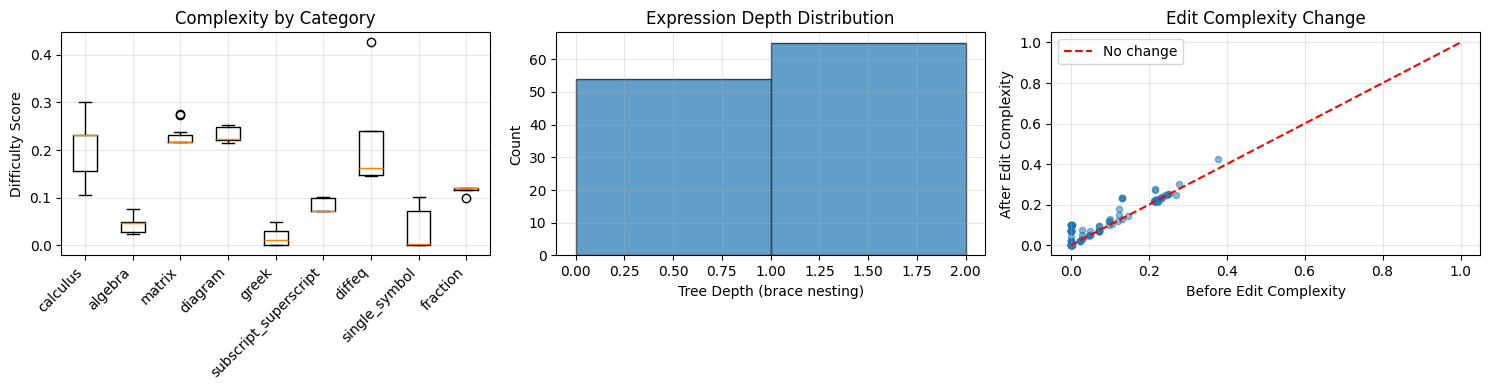


Complexity Summary by Category:
------------------------------------------------------------
algebra                   | Mean: 0.045 | Max: 0.077 | Count: 10
calculus                  | Mean: 0.205 | Max: 0.300 | Count: 10
diagram                   | Mean: 0.232 | Max: 0.253 | Count: 12
diffeq                    | Mean: 0.224 | Max: 0.426 | Count: 4
fraction                  | Mean: 0.115 | Max: 0.121 | Count: 4
greek                     | Mean: 0.019 | Max: 0.050 | Count: 4
matrix                    | Mean: 0.230 | Max: 0.276 | Count: 10
single_symbol             | Mean: 0.036 | Max: 0.102 | Count: 55
subscript_superscript     | Mean: 0.083 | Max: 0.101 | Count: 10


In [12]:
# Analyze complexity distribution across all generated cases
complexity_data = []
for case in cases:
    before_complexity = analyze_latex_complexity(case.before_latex)
    after_complexity = analyze_latex_complexity(case.after_latex)
    complexity_data.append({
        'category': case.category,
        'operation': case.operation,
        'before_depth': before_complexity.depth,
        'after_depth': after_complexity.depth,
        'before_score': before_complexity.difficulty_score,
        'after_score': after_complexity.difficulty_score,
        'delta_complexity': after_complexity.difficulty_score - before_complexity.difficulty_score,
    })

# Visualize complexity distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Difficulty score distribution by category
categories = list(set(d['category'] for d in complexity_data))
category_scores = {cat: [d['after_score'] for d in complexity_data if d['category'] == cat] for cat in categories}

ax = axes[0]
positions = range(len(categories))
ax.boxplot([category_scores[cat] for cat in categories], positions=positions)
ax.set_xticks(positions)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_ylabel('Difficulty Score')
ax.set_title('Complexity by Category')
ax.grid(True, alpha=0.3)

# 2. Depth distribution
ax = axes[1]
depths = [d['after_depth'] for d in complexity_data]
ax.hist(depths, bins=range(max(depths) + 2), edgecolor='black', alpha=0.7)
ax.set_xlabel('Tree Depth (brace nesting)')
ax.set_ylabel('Count')
ax.set_title('Expression Depth Distribution')
ax.grid(True, alpha=0.3)

# 3. Before vs After complexity
ax = axes[2]
before_scores = [d['before_score'] for d in complexity_data]
after_scores = [d['after_score'] for d in complexity_data]
ax.scatter(before_scores, after_scores, alpha=0.5, s=20)
ax.plot([0, 1], [0, 1], 'r--', label='No change')
ax.set_xlabel('Before Edit Complexity')
ax.set_ylabel('After Edit Complexity')
ax.set_title('Edit Complexity Change')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nComplexity Summary by Category:")
print("-" * 60)
for cat in sorted(categories):
    scores = category_scores[cat]
    print(f"{cat:25} | Mean: {sum(scores)/len(scores):.3f} | "
          f"Max: {max(scores):.3f} | Count: {len(scores)}")


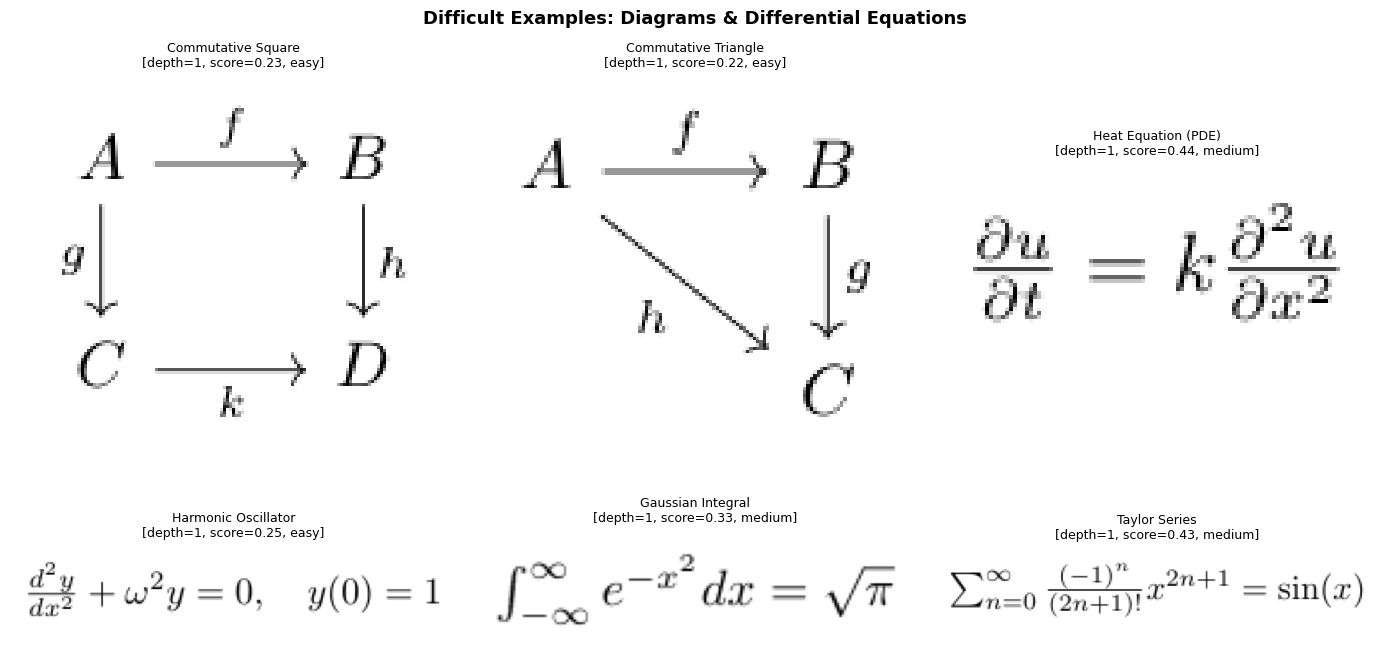

In [13]:
# Render and display difficult examples: Diagrams and Differential Equations
difficult_examples = [
    # Commutative diagrams (use regular strings with proper escaping for tikzcd quotes)
    ("\\begin{tikzcd} A \\arrow[r, \"f\"] \\arrow[d, \"g\"'] & B \\arrow[d, \"h\"] \\\\ C \\arrow[r, \"k\"'] & D \\end{tikzcd}", 
     "Commutative Square"),
    ("\\begin{tikzcd} A \\arrow[r, \"f\"] \\arrow[dr, \"h\"'] & B \\arrow[d, \"g\"] \\\\ & C \\end{tikzcd}",
     "Commutative Triangle"),
    # Differential equations  
    (r"$\frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2}$",
     "Heat Equation (PDE)"),
    (r"$\frac{d^2y}{dx^2} + \omega^2 y = 0, \quad y(0) = 1$",
     "Harmonic Oscillator"),
    # Complex expressions
    (r"$\int_{-\infty}^{\infty} e^{-x^2} dx = \sqrt{\pi}$",
     "Gaussian Integral"),
    (r"$\sum_{n=0}^{\infty} \frac{(-1)^n}{(2n+1)!} x^{2n+1} = \sin(x)$",
     "Taylor Series"),
]

num_examples = len(difficult_examples)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, (latex, title) in enumerate(difficult_examples):
    ax = axes[idx]
    
    # Analyze complexity
    complexity = analyze_latex_complexity(latex)
    cat = difficulty_category(complexity.difficulty_score)
    
    # Render
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        tmp_path = tmp.name
    
    success = render_tikzcd_to_image(latex, tmp_path, dpi=150)
    
    if success and os.path.exists(tmp_path):
        img = Image.open(tmp_path)
        ax.imshow(img)
        os.remove(tmp_path)
    else:
        ax.text(0.5, 0.5, "Render Failed", ha="center", va="center", 
                transform=ax.transAxes, fontsize=12, color='red')
        ax.set_facecolor("#f8f8f8")
    
    ax.set_title(f"{title}\n[depth={complexity.depth}, score={complexity.difficulty_score:.2f}, {cat}]", 
                 fontsize=9)
    ax.axis("off")

fig.suptitle("Difficult Examples: Diagrams & Differential Equations", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()


## 7. Cleanup

In [14]:
# Optionally clean up demo output
# shutil.rmtree(output_dir)
# print(f"Cleaned up {output_dir}")

print("Demo complete!")
print(f"Output saved to: {output_dir}/")

Demo complete!
Output saved to: demo_output/


## Summary

### Pipeline Flow
```
synthetic_case_generator.py       generate_tikzcd.py
────────                          ──────────────────
CaseGenerator                     render_tikzcd_to_image()
    │                                    │
    ▼                                    ▼
generate_all()                    LaTeX → PDF → PNG
    │                                    │
    ▼                                    ▼
convert_to_training_examples()    generate_training_dataset()
    │                                    │
    ▼                                    ▼
TrainingExample                   Output Files:
  - latex_context                   - context_images/
  - crop_spec                       - crop_images/
  - updated_latex                   - target_images/
  - operation (ADD/REPLACE/INSERT)  - dataset.json
```

### Key Classes
- `CaseGenerator`: Creates diverse editing scenarios
- `TrainingExample`: Input-output pair for model training
- `TikzCDGenerator`: LaTeX templates (matrix, integral, etc.)
- `ExpressionComplexity`: Analyzes LaTeX expression difficulty

### Complexity Features
The expression complexity analyzer extracts:
- **depth**: Brace nesting level (tree depth)
- **num_operators**: Binary operators (+, -, ×, etc.)
- **num_functions**: Functions (sin, cos, log, etc.)
- **num_fractions**: Fraction constructs
- **num_scripts**: Subscripts and superscripts
- **num_special**: Special constructs (∫, ∑, ∂, matrices, diagrams)
- **difficulty_score**: Weighted combination (0-1 scale)

### Difficulty Categories
| Score Range | Category | Example |
|-------------|----------|---------|
| 0.0 - 0.2   | easy     | `x + y` |
| 0.2 - 0.4   | medium   | `x^2 + y^2` |
| 0.4 - 0.6   | hard     | `\int_0^1 x^2 dx` |
| 0.6 - 1.0   | expert   | PDEs, commutative diagrams |

## 8. Confusion Group Visualization

Visualize symbols that are easily confused in handwriting to understand disambiguation challenges.


In [ ]:
# Load confusion groups and stroke data
import json
import numpy as np
from pathlib import Path

# Load confusion groups
with open("symbol_confusion_groups.json", "r", encoding="utf-8") as f:
    confusion_data = json.load(f)

# Load stroke data
with open("stroke_corpus/annotations/stroke_data_merged.json", "r", encoding="utf-8") as f:
    stroke_data = json.load(f)

print(f"Loaded {len(confusion_data['confusion_groups'])} confusion groups")
print(f"Loaded {len(stroke_data)} symbols with stroke data")
print(f"\nPriority groups: {confusion_data['priority_groups']}")


In [ ]:
def render_stroke_original(symbol_data: dict, canvas_size: int = 128, line_width: float = 2.0) -> np.ndarray:
    """Render a symbol using its FIRST variation of each stroke (original, no augmentation)."""
    from PIL import Image, ImageDraw
    
    canvas = Image.new("L", (canvas_size, canvas_size), 255)
    draw = ImageDraw.Draw(canvas)
    
    strokes = symbol_data.get("strokes", {})
    
    for stroke_key in sorted(strokes.keys()):
        stroke = strokes[stroke_key]
        variations = stroke.get("variations", [])
        if not variations:
            continue
        
        # Use first variation (original)
        points = variations[0]
        if len(points) < 2:
            continue
        
        # Scale to canvas (points are normalized 0-1)
        margin = 10
        usable = canvas_size - 2 * margin
        scaled = [(int(p[0] * usable + margin), int(p[1] * usable + margin)) for p in points]
        
        # Draw the stroke
        draw.line(scaled, fill=0, width=int(line_width))
    
    return np.array(canvas)


def render_all_variations(symbol_data: dict, canvas_size: int = 80, line_width: float = 1.5) -> list:
    """Render ALL variations of a symbol (combinatorially combining stroke variations)."""
    from PIL import Image, ImageDraw
    import itertools
    
    strokes = symbol_data.get("strokes", {})
    if not strokes:
        return []
    
    # Get all variations for each stroke
    stroke_keys = sorted(strokes.keys())
    all_variations = []
    for key in stroke_keys:
        variations = strokes[key].get("variations", [])
        if variations:
            all_variations.append(variations)
    
    if not all_variations:
        return []
    
    # Limit combinatorial explosion
    max_per_stroke = 3  # Only take first 3 variations per stroke
    all_variations = [v[:max_per_stroke] for v in all_variations]
    
    # Generate all combinations
    rendered = []
    for combo in itertools.product(*all_variations):
        canvas = Image.new("L", (canvas_size, canvas_size), 255)
        draw = ImageDraw.Draw(canvas)
        
        margin = 8
        usable = canvas_size - 2 * margin
        
        for stroke_points in combo:
            if len(stroke_points) < 2:
                continue
            scaled = [(int(p[0] * usable + margin), int(p[1] * usable + margin)) for p in stroke_points]
            draw.line(scaled, fill=0, width=int(line_width))
        
        rendered.append(np.array(canvas))
        if len(rendered) >= 9:  # Max 9 variations to display
            break
    
    return rendered

print("Stroke rendering functions defined.")


In [ ]:
# Visualize priority confusion groups - ORIGINAL strokes only
priority_groups = confusion_data["priority_groups"]

for group_id in priority_groups:
    # Find the group
    group = next((g for g in confusion_data["confusion_groups"] if g["id"] == group_id), None)
    if not group:
        continue
    
    symbols = group["symbols"]
    latex_names = group["latex"]
    
    # Check which symbols have stroke data
    available = []
    for sym, latex in zip(symbols, latex_names):
        if sym in stroke_data:
            available.append((sym, latex, stroke_data[sym]))
        else:
            # Try latex key
            if latex in stroke_data:
                available.append((sym, latex, stroke_data[latex]))
    
    if not available:
        print(f"⚠️ Group '{group_id}': No stroke data available for {symbols}")
        continue
    
    # Create figure
    n = len(available)
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    if n == 1:
        axes = [axes]
    
    fig.suptitle(f"Confusion Group: {group_id}\n{group['notes']}", fontsize=11, fontweight="bold")
    
    for ax, (sym, latex, sym_data) in zip(axes, available):
        img = render_stroke_original(sym_data, canvas_size=128, line_width=2.5)
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)
        
        # Count strokes and variations
        n_strokes = len(sym_data.get("strokes", {}))
        n_vars = sum(len(s.get("variations", [])) for s in sym_data.get("strokes", {}).values())
        
        ax.set_title(f"'{sym}' ({latex})\n{n_strokes} strokes, {n_vars} vars", fontsize=9)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()
    print(f"✅ {group_id}: {[a[0] for a in available]} ({group['difficulty']} difficulty)\n")


In [ ]:
# Deep dive: Show ALL variations for the most confusing pair (1, l, I)
focus_symbols = ["1", "l", "I"]

fig, axes = plt.subplots(len(focus_symbols), 9, figsize=(16, 5.5))
fig.suptitle("1 vs l vs I: All Handwriting Variations\n(Most commonly confused symbols)", 
             fontsize=12, fontweight="bold")

for row, sym in enumerate(focus_symbols):
    if sym not in stroke_data:
        for col in range(9):
            axes[row, col].axis("off")
        continue
    
    sym_data = stroke_data[sym]
    variations = render_all_variations(sym_data, canvas_size=80, line_width=2.0)
    
    for col in range(9):
        ax = axes[row, col]
        if col < len(variations):
            ax.imshow(variations[col], cmap="gray", vmin=0, vmax=255)
        ax.axis("off")
        if col == 0:
            ax.set_ylabel(f"'{sym}'", fontsize=11, fontweight="bold", rotation=0, labelpad=25)
    
    # Label with variation count
    n_strokes = len(sym_data.get("strokes", {}))
    total_vars = 1
    for s in sym_data.get("strokes", {}).values():
        total_vars *= len(s.get("variations", [1]))
    print(f"'{sym}': {n_strokes} strokes, {total_vars} total combinations")

plt.tight_layout()
plt.show()


In [ ]:
# Greek vs Latin confusion: alpha/a, nu/v, chi/x
greek_pairs = [
    ("α", "a", "alpha_a"),
    ("ν", "v", "nu_v"),  
    ("χ", "x", "chi_x"),
    ("ε", "e", "epsilon_e_in"),
]

fig, axes = plt.subplots(len(greek_pairs), 4, figsize=(10, 8))
fig.suptitle("Greek vs Latin: High-Confusion Pairs\n(Original handwriting)", fontsize=12, fontweight="bold")

for row, (greek, latin, group_id) in enumerate(greek_pairs):
    # Find both symbols in stroke data
    symbols_to_show = []
    for sym in [greek, latin]:
        if sym in stroke_data:
            symbols_to_show.append((sym, stroke_data[sym]))
    
    # Show original + 1 variation for each
    col_idx = 0
    for sym, sym_data in symbols_to_show:
        variations = render_all_variations(sym_data, canvas_size=100, line_width=2.0)
        
        for var_img in variations[:2]:  # Show first 2 variations
            if col_idx < 4:
                ax = axes[row, col_idx]
                ax.imshow(var_img, cmap="gray", vmin=0, vmax=255)
                ax.set_title(f"'{sym}'", fontsize=10)
                ax.axis("off")
                col_idx += 1
    
    # Fill remaining with blank
    while col_idx < 4:
        axes[row, col_idx].axis("off")
        col_idx += 1
    
    # Row label
    axes[row, 0].set_ylabel(group_id.replace("_", "/"), fontsize=10, rotation=0, labelpad=50)

plt.tight_layout()
plt.show()

print("\n⚠️ Notice how similar some Greek letters look to their Latin counterparts!")


In [ ]:
# Summary: Which confusion group symbols are missing stroke data?
print("=" * 60)
print("CONFUSION GROUP COVERAGE ANALYSIS")
print("=" * 60)

all_confusion_symbols = set()
available_symbols = set()
missing_symbols = set()

for group in confusion_data["confusion_groups"]:
    for sym in group["symbols"]:
        all_confusion_symbols.add(sym)
        if sym in stroke_data:
            available_symbols.add(sym)
        else:
            missing_symbols.add(sym)

print(f"\nTotal unique symbols in confusion groups: {len(all_confusion_symbols)}")
print(f"Symbols with stroke data: {len(available_symbols)} ({100*len(available_symbols)/len(all_confusion_symbols):.1f}%)")
print(f"Symbols MISSING stroke data: {len(missing_symbols)}")

if missing_symbols:
    print(f"\nMissing symbols (need to capture):")
    # Group by type
    missing_list = sorted(list(missing_symbols))
    for i in range(0, len(missing_list), 10):
        print(f"  {missing_list[i:i+10]}")

# Show which priority groups are fully covered
print("\n" + "-" * 40)
print("Priority Groups Status:")
for group_id in confusion_data["priority_groups"]:
    group = next((g for g in confusion_data["confusion_groups"] if g["id"] == group_id), None)
    if not group:
        continue
    
    symbols = group["symbols"]
    present = [s for s in symbols if s in stroke_data]
    missing = [s for s in symbols if s not in stroke_data]
    
    status = "✅" if len(missing) == 0 else "⚠️"
    print(f"  {status} {group_id}: {len(present)}/{len(symbols)} available")
    if missing:
        print(f"      Missing: {missing}")
